[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)



# 代理记忆（Agent memory）

## 评审（Review）

Previously, we built an agent that can:

之前，我们构建了一个能够执行以下操作的代理：

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

*`act` - 让模型调用特定工具* `observe` - 将工具输出传回给模型  
* `reason` - 让模型根据工具输出进行推理，以决定下一步操作（例如，调用另一个工具或直接响应）

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## 目标（Goals）

Now, we're going extend our agent by introducing memory.

现在，我们将通过引入记忆功能来扩展我们的代理。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 用于 [tracing](https://docs.smith.langchain.com/concepts/tracing)。



In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

This follows what we did previously.

这遵循我们之前所做的。



In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)
llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="你是一个乐于助人的助手，负责对一组输入执行算术运算。")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

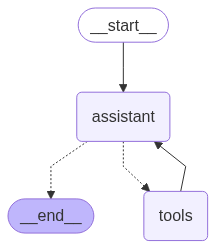

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## 内存（Memory）

Let's run our agent, as before.

让我们像之前一样运行我们的代理。



In [7]:
messages = [HumanMessage(content="3加4")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

3加4
================================== Ai Message ==================================
Tool Calls:
  add (call_3b60c2e42db1409db1fd7f)
 Call ID: call_3b60c2e42db1409db1fd7f
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

3加4的结果是7。


Now, let's multiply by 2!

现在，让我们乘以 2！



In [7]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_prnkuG7OYQtbrtVQmH2d3Nl7)
 Call ID: call_prnkuG7OYQtbrtVQmH2d3Nl7
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================

The result of multiplying 2 by 2 is 4.


We don't retain memory of 7 from our initial chat!

我们不会保留初始聊天中关于 PROTECTED$7$ 的记忆！

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

这是因为 [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) 对应于单个图执行。

Of course, this limits our ability to have multi-turn conversations with interruptions. 

当然，这限制了我们进行带有中断的多轮对话的能力。

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

我们可以使用 [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) 来解决这个问题！

LangGraph can use a checkpointer to automatically save the graph state after each step.

LangGraph 可以使用检查点工具在每一步之后自动保存图的状态。

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

这一内置的持久化层为我们提供了内存功能，使 LangGraph 能够从最后一次状态更新处继续。

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

最简单的检查点之一是 `MemorySaver`，这是一个用于图形状态的内存键值存储。

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

我们只需要用检查点编译图，这样我们的图就有了记忆功能！



In [8]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

当我们使用内存时，我们需要指定一个 `thread_id`.

This `thread_id` will store our collection of graph states.

这 `thread_id` 将存储我们的图形状态集合。

Here is a cartoon:

这里有一幅漫画：

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

检查点在图的每一步写入状态 这些检查点保存在一个线程中  
我们可以使用 `thread_id` 在未来访问该线程

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)




In [9]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_MSupVAgej4PShIZs7NXOE6En)
 Call ID: call_MSupVAgej4PShIZs7NXOE6En
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

如果我们传递相同的 `thread_id`，那么我们可以从之前记录的状态检查点继续！

In this case, the above conversation is captured in the thread.

在这种情况下，上述对话被记录在了线程中。

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

我们传递的 `HumanMessage`（`"Multiply that by 2."`）会被添加到上述对话中。

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

因此，模型现在知道 `that` 指的是 `The sum of 3 and 4 is 7.`。



In [10]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_MSupVAgej4PShIZs7NXOE6En)
 Call ID: call_MSupVAgej4PShIZs7NXOE6En
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_fWN7lnSZZm82tAg7RGeuWusO)
 Call ID: call_fWN7lnSZZm82tAg7RGeuWusO
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## 朗格拉夫工作室（LangGraph Studio）


**⚠️ DISCLAIMER**

**⚠️ 注意事项**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `module-1/studio/` directory in this module:

自从这些视频的录制以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中所示使用桌面应用程序）。请参阅关于 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 本地开发服务器的文档和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `module-1/studio/` 目录中的终端运行以下命令：

```
langgraph dev
```

